In [ ]:
!nvidia-smi

Fri Jul 23 14:34:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Header Files

In [ ]:
import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
from torchvision import transforms
from torch.distributions import Normal, Bernoulli, kl_divergence as kl
import torch.nn.functional as F


from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from tqdm.auto import tqdm
import time
from sklearn.metrics import accuracy_score

import scipy

In [ ]:
!pip install umap-learn datashader bokeh holoviews

     |████████████████████████████████| 80 kB 3.1 MB/s 
     |████████████████████████████████| 15.8 MB 1.1 kB/s 
     |████████████████████████████████| 1.1 MB 48.0 MB/s 
     |████████████████████████████████| 76 kB 4.5 MB/s 
     |████████████████████████████████| 1.0 MB 45.0 MB/s 
     |████████████████████████████████| 118 kB 58.4 MB/s 
     |████████████████████████████████| 722 kB 46.9 MB/s 
     |████████████████████████████████| 722 kB 46.7 MB/s 
     |████████████████████████████████| 715 kB 50.2 MB/s 
     |████████████████████████████████| 705 kB 30.1 MB/s 
     |████████████████████████████████| 699 kB 57.9 MB/s 
     |████████████████████████████████| 696 kB 56.0 MB/s 
     |████████████████████████████████| 684 kB 58.0 MB/s 
     |████████████████████████████████| 679 kB 63.0 MB/s 
     |████████████████████████████████| 675 kB 45.3 MB/s 
     |████████████████████████████████| 675 kB 47.8 MB/s 
     |████████████████████████████████| 672 kB 55.0 MB/s 
     |████████████

In [ ]:
import umap
import umap.plot

###FEDERATED LEARNING ALGOS

In [ ]:
def split_iid(dataset, n_centers):
    """ Split PyTorch dataset randomly into n_centers """
    n_obs_per_center = [len(dataset) // n_centers for _ in range(n_centers)]
    return random_split(dataset, n_obs_per_center)

In [ ]:
def federated_averaging(models, n_obs_per_client):
    assert len(models) > 0, 'An empty list of models was passed.'
    assert len(n_obs_per_client) == len(models), 'List with number of observations must have ' \
                                                 'the same number of elements that list of models.'

    # Compute proportions
    n_obs = sum(n_obs_per_client)
    
    proportions = [n_k / n_obs for n_k in n_obs_per_client]

    # Empty model parameter dictionary
    avg_params = models[0].state_dict()
    for key, val in avg_params.items():
        avg_params[key] = torch.zeros_like(val)

    # Compute average
    for model, proportion in zip(models, proportions):
        for key in avg_params.keys():
            avg_params[key] += proportion * model.state_dict()[key]

    # Copy one of the models and load trained params
    avg_model = copy.deepcopy(models[0])
    avg_model.load_state_dict(avg_params)
  
    return avg_model

###PARAMETERS

In [ ]:
N_CENTERS = 2
N_ROUNDS = 50   

BATCH_SIZE = 8
LR = 1e-6

# Dataloader for sparse matrix

In [ ]:
class SparseDataset(Dataset):
    def __init__(self, mat_csc):
        self.dim = mat_csc.shape

        csr = mat_csc.tocsr(copy=True) # Converts matrix to Compressed Sparse Row format

        self.data = torch.tensor(csr.data, dtype=torch.float32)                 # array containing all the non zero elements of sparse matrix
        self.indices = torch.tensor(csr.indices, dtype=torch.int64)             # array mapping each element of data to columns of sparse matrix
        self.indptr = torch.tensor(csr.indptr, dtype=torch.int64)               # maps elements of indices and data to the rows of sparse matrix
        

    def __len__(self):
        return self.dim[0]

    def __getitem__(self, idx):
        obs = torch.zeros((self.dim[1],), dtype=torch.float32)
        ind1,ind2 = self.indptr[idx],self.indptr[idx+1]
        obs[self.indices[ind1:ind2]] = self.data[ind1:ind2]

        return obs

In [ ]:
train_sparse = scipy.io.mmread("/content/drive/MyDrive/Federated Learning/Data/Fixed_depth_Fixed_rou/3000 depth/rou0.6/peakMat.fixLen.400_400_400_400_400.rou0.6.rdepth3000.mtx")
type(train_sparse)

scipy.sparse.coo.coo_matrix

In [ ]:
train_dataset = SparseDataset(train_sparse)

In [ ]:
train_dataset[0].shape

torch.Size([90635])

In [ ]:
federated_dataset = split_iid(train_dataset, n_centers=N_CENTERS)

print('Number of centers:', len(federated_dataset))
#train_data_loader = DataLoader(dataset= federated_dataset, batch_size=BATCH_SIZE, shuffle=False)

Number of centers: 2


###W

In [ ]:
ones = train_sparse.count_nonzero()
ones

5871458

In [ ]:
total_elements = train_sparse.shape[0] * train_sparse.shape[1]
zeros = total_elements - ones
ω = zeros/ones

print(f"Total elements: {total_elements} \t Ones: {ones} \t Zeros: {zeros} \n ω: {ω}")

Total elements: 181270000 	 Ones: 5871458 	 Zeros: 175398542 
 ω: 29.873081268741085


#  Labels

In [ ]:

labels = pd.read_csv("/content/drive/MyDrive/Federated Learning/Data/Fixed_depth_Fixed_rou/3000 depth/rou0.6/cellLabel.fixLen.400_400_400_400_400.rou0.6.rdepth3000.txt", sep="\t", header=None)

labels.head()

,0,1
0,1,MONO
1,1,MONO
2,1,MONO
3,1,MONO
4,1,MONO


# VAE MODEL

## My model

In [ ]:
d = 10
class VAE(nn.Module):
    
    def __init__(self):
        super().__init__()

        

        self.encoder = nn.Sequential(
            nn.Linear(train_sparse.shape[1], d ** 3),
            nn.ReLU(), 
            nn.Linear(d ** 3, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)          
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(), 
            nn.Linear(d ** 2, d ** 3),
            nn.ReLU(),
            nn.Linear(d ** 3, train_sparse.shape[1]),
            nn.Sigmoid(),
          
            
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        x = x.view(-1, train_sparse.shape[1])

        mu_logvar = self.encoder(x).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)

        
        return self.decoder(z), mu, logvar, z

# Train

In [ ]:
device = torch.device("cuda:0") #if torch.cuda.is_available() else "cpu")
#device = torch.device( "cpu")
device

device(type='cuda', index=0)

In [ ]:
train_sparse.shape[1]

90635

In [ ]:
model = VAE().to(device)

In [ ]:
def get_data(subset, shuffle=False):
    """ Extracts data from a Subset torch dataset in the form of a tensor"""
    loader = DataLoader(subset, batch_size=len(subset), shuffle=shuffle)
    return iter(loader).next()

In [ ]:
#x = next(iter(train_data_loader)).to(device)

In [ ]:
#x.shape

In [ ]:
model(get_data(federated_dataset[0]).to(device))

(tensor([[0.4741, 0.5078, 0.5397,  ..., 0.4675, 0.4932, 0.4736],
         [0.4756, 0.5502, 0.4907,  ..., 0.5183, 0.4828, 0.4967],
         [0.5249, 0.5465, 0.4588,  ..., 0.5122, 0.5304, 0.5010],
         ...,
         [0.4795, 0.5113, 0.4942,  ..., 0.5062, 0.5144, 0.4677],
         [0.4961, 0.5144, 0.4980,  ..., 0.4752, 0.4775, 0.5128],
         [0.4857, 0.5064, 0.5024,  ..., 0.4681, 0.5085, 0.4952]],
        device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[-0.0508,  0.0108, -0.0522,  ..., -0.0110,  0.0031,  0.0555],
         [-0.0605,  0.0042, -0.0351,  ..., -0.0232, -0.0094,  0.0507],
         [-0.0622,  0.0005, -0.0459,  ..., -0.0254, -0.0163,  0.0427],
         ...,
         [-0.0598,  0.0182, -0.0645,  ..., -0.0104, -0.0240,  0.0525],
         [-0.0484,  0.0020, -0.0446,  ..., -0.0149, -0.0066,  0.0578],
         [-0.0461,  0.0144, -0.0446,  ..., -0.0256, -0.0353,  0.0354]],
        device='cuda:0', grad_fn=<SliceBackward>),
 tensor([[ 0.0761, -0.0232,  0.0142,  ..., -0.1122

In [ ]:
import copy
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
models = [copy.deepcopy(model) for _ in range(N_CENTERS)]
n_obs_per_client = [len(client_data) for client_data in federated_dataset]

In [ ]:
n_obs_per_client

[1000, 1000]

In [ ]:
for model in models:
  optimizer= torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters: "+str(params))

Trainable Parameters: 181565855


In [ ]:
def plot_UMAP(combined, z):
    mapper = umap.UMAP(n_neighbors=20).fit(combined )
    umap.plot.points(mapper, labels=labels[1],color_key_cmap='Paired', background='black')
    plt.title("COMBINED")
    plt.show()

    mapper = umap.UMAP(n_neighbors=20).fit(z)
    umap.plot.points(mapper, labels=labels[1],color_key_cmap='Paired', background='black')
    plt.title("MEAN")
    plt.show()

    plt.clf()

## Train with my loss

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar,ω=1):
    eps = 1e-12
    #x = x.view(-1, train_sparse.shape[1])

    #BCE = nn.functional.binary_cross_entropy(x_hat, x.view(-1, 90635), reduction='sum')
    
    own_BCE = ω * x * x_hat.clamp(min=eps).log() + (1 - x) * (1 - x_hat).clamp(min=eps).log()
    own_BCE = torch.neg(torch.sum(own_BCE))

    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))


    return own_BCE, KLD

============ Epoch: 0 ============
tensor([[ 0.0029,  0.0031, -0.0032,  ..., -0.0012, -0.0028,  0.0021],
        [ 0.0008,  0.0028, -0.0024,  ...,  0.0025,  0.0011,  0.0011],
        [-0.0028, -0.0004,  0.0018,  ...,  0.0002,  0.0014, -0.0025],
        ...,
        [-0.0016, -0.0028, -0.0029,  ...,  0.0015, -0.0011, -0.0033],
        [ 0.0002, -0.0013,  0.0027,  ...,  0.0002, -0.0026,  0.0026],
        [ 0.0017, -0.0020, -0.0013,  ..., -0.0019,  0.0026, -0.0026]],
       device='cuda:0')



Average loss: 5507733964.8581	 Avg KLD loss: 1123.1989	 
               Avg BCE loss: 5507732849.9768



Average loss: 11004872502.7845	 Avg KLD loss: 2181.6984	 
               Avg BCE loss: 11004870327.8985
============ Epoch: 1 ============
tensor([[ 0.0028,  0.0031, -0.0032,  ..., -0.0012, -0.0028,  0.0021],
        [ 0.0008,  0.0027, -0.0024,  ...,  0.0025,  0.0010,  0.0011],
        [-0.0028, -0.0004,  0.0018,  ...,  0.0002,  0.0014, -0.0025],
        ...,
        [-0.0015, -0.0028, -0.0029,  ...,  0.0014, -0.0011, -0.0032],
        [ 0.0002, -0.0013,  0.0027,  ...,  0.0002, -0.0026,  0.0026],
        [ 0.0017, -0.0020, -0.0013,  ..., -0.0018,  0.0026, -0.0026]],
       device='cuda:0')



Average loss: 5478710661.5902	 Avg KLD loss: 6761.0654	 
               Avg BCE loss: 5478703897.2453



Average loss: 10933474946.1644	 Avg KLD loss: 79309.9149	 
               Avg BCE loss: 10933395623.8994
============ Epoch: 2 ============
tensor([[ 0.0029,  0.0032, -0.0031,  ..., -0.0012, -0.0026,  0.0023],
        [ 0.0008,  0.0028, -0.0024,  ...,  0.0025,  0.0011,  0.0012],
        [-0.0028, -0.0004,  0.0018,  ...,  0.0002,  0.0013, -0.0026],
        ...,
        [-0.0015, -0.0028, -0.0029,  ...,  0.0014, -0.0011, -0.0032],
        [ 0.0002, -0.0013,  0.0027,  ...,  0.0002, -0.0026,  0.0025],
        [ 0.0018, -0.0019, -0.0012,  ..., -0.0017,  0.0029, -0.0024]],
       device='cuda:0')



Average loss: 5407873102.5228	 Avg KLD loss: 378848.2253	 
               Avg BCE loss: 5407494254.2416



Average loss: 10755451942.2071	 Avg KLD loss: 1396802.6774	 
               Avg BCE loss: 10754055146.0416
============ Epoch: 3 ============
tensor([[ 0.0030,  0.0033, -0.0030,  ..., -0.0010, -0.0023,  0.0026],
        [ 0.0008,  0.0028, -0.0024,  ...,  0.0025,  0.0012,  0.0012],
        [-0.0028, -0.0004,  0.0018,  ...,  0.0002,  0.0013, -0.0026],
        ...,
        [-0.0016, -0.0028, -0.0029,  ...,  0.0014, -0.0012, -0.0033],
        [ 0.0002, -0.0013,  0.0027,  ...,  0.0002, -0.0027,  0.0024],
        [ 0.0019, -0.0018, -0.0011,  ..., -0.0015,  0.0032, -0.0020]],
       device='cuda:0')



Average loss: 5283418315.0413	 Avg KLD loss: 1743700.5801	 
               Avg BCE loss: 5281674612.3512



Average loss: 10510263922.8360	 Avg KLD loss: 3983086.9261	 
               Avg BCE loss: 10506280833.2246
============ Epoch: 4 ============
tensor([[ 0.0031,  0.0033, -0.0029,  ..., -0.0010, -0.0022,  0.0028],
        [ 0.0008,  0.0028, -0.0024,  ...,  0.0025,  0.0013,  0.0013],
        [-0.0028, -0.0005,  0.0018,  ...,  0.0002,  0.0013, -0.0026],
        ...,
        [-0.0016, -0.0028, -0.0029,  ...,  0.0014, -0.0012, -0.0033],
        [ 0.0002, -0.0013,  0.0027,  ...,  0.0001, -0.0027,  0.0024],
        [ 0.0020, -0.0018, -0.0010,  ..., -0.0014,  0.0034, -0.0018]],
       device='cuda:0')



Average loss: 5168625630.6657	 Avg KLD loss: 2680437.5141	 
               Avg BCE loss: 5165945198.2566



Average loss: 10288608932.8366	 Avg KLD loss: 5653241.1245	 
               Avg BCE loss: 10282955697.5645
============ Epoch: 5 ============
tensor([[ 0.0031,  0.0033, -0.0030,  ..., -0.0010, -0.0022,  0.0028],
        [ 0.0009,  0.0028, -0.0024,  ...,  0.0025,  0.0014,  0.0014],
        [-0.0028, -0.0005,  0.0018,  ...,  0.0002,  0.0013, -0.0026],
        ...,
        [-0.0016, -0.0028, -0.0029,  ...,  0.0014, -0.0012, -0.0033],
        [ 0.0002, -0.0013,  0.0027,  ...,  0.0002, -0.0026,  0.0025],
        [ 0.0020, -0.0018, -0.0010,  ..., -0.0015,  0.0035, -0.0017]],
       device='cuda:0')



Average loss: 5074549573.0506	 Avg KLD loss: 3194340.2978	 
               Avg BCE loss: 5071355233.8187



Average loss: 10116039554.0175	 Avg KLD loss: 6493708.4296	 
               Avg BCE loss: 10109545847.9989
============ Epoch: 6 ============
tensor([[ 0.0031,  0.0033, -0.0030,  ..., -0.0010, -0.0021,  0.0028],
        [ 0.0009,  0.0028, -0.0024,  ...,  0.0026,  0.0014,  0.0014],
        [-0.0028, -0.0004,  0.0018,  ...,  0.0002,  0.0013, -0.0026],
        ...,
        [-0.0016, -0.0028, -0.0029,  ...,  0.0014, -0.0012, -0.0033],
        [ 0.0002, -0.0013,  0.0028,  ...,  0.0002, -0.0025,  0.0027],
        [ 0.0021, -0.0018, -0.0011,  ..., -0.0015,  0.0035, -0.0016]],
       device='cuda:0')



Average loss: 5008734959.3036	 Avg KLD loss: 3327875.7806	 
               Avg BCE loss: 5005407080.0204



Average loss: 9995403786.9708	 Avg KLD loss: 6630728.9195	 
               Avg BCE loss: 9988773052.5156
============ Epoch: 7 ============
tensor([[ 0.0031,  0.0033, -0.0031,  ..., -0.0011, -0.0022,  0.0028],
        [ 0.0010,  0.0029, -0.0023,  ...,  0.0025,  0.0015,  0.0015],
        [-0.0028, -0.0004,  0.0018,  ...,  0.0002,  0.0013, -0.0026],
        ...,
        [-0.0016, -0.0028, -0.0029,  ...,  0.0014, -0.0012, -0.0033],
        [ 0.0003, -0.0012,  0.0028,  ...,  0.0002, -0.0024,  0.0028],
        [ 0.0021, -0.0018, -0.0011,  ..., -0.0016,  0.0035, -0.0016]],
       device='cuda:0')



Average loss: 4963889214.8326	 Avg KLD loss: 3261040.2624	 
               Avg BCE loss: 4960628173.5513



Average loss: 9914050560.4798	 Avg KLD loss: 6430378.7941	 
               Avg BCE loss: 9907620183.1891
============ Epoch: 8 ============
tensor([[ 0.0031,  0.0033, -0.0032,  ..., -0.0011, -0.0022,  0.0028],
        [ 0.0010,  0.0029, -0.0023,  ...,  0.0025,  0.0015,  0.0015],
        [-0.0028, -0.0004,  0.0018,  ...,  0.0002,  0.0013, -0.0026],
        ...,
        [-0.0016, -0.0028, -0.0029,  ...,  0.0014, -0.0012, -0.0033],
        [ 0.0003, -0.0012,  0.0028,  ...,  0.0001, -0.0024,  0.0029],
        [ 0.0021, -0.0018, -0.0012,  ..., -0.0016,  0.0035, -0.0016]],
       device='cuda:0')



Average loss: 4933921182.2448	 Avg KLD loss: 3092093.8384	 
               Avg BCE loss: 4930829093.1006



Average loss: 9859574708.4740	 Avg KLD loss: 6094351.7886	 
               Avg BCE loss: 9853480359.3837
============ Epoch: 9 ============
tensor([[ 0.0031,  0.0033, -0.0031,  ..., -0.0012, -0.0022,  0.0028],
        [ 0.0011,  0.0029, -0.0023,  ...,  0.0026,  0.0015,  0.0015],
        [-0.0028, -0.0004,  0.0018,  ...,  0.0002,  0.0013, -0.0026],
        ...,
        [-0.0016, -0.0028, -0.0029,  ...,  0.0014, -0.0012, -0.0033],
        [ 0.0003, -0.0012,  0.0028,  ...,  0.0001, -0.0024,  0.0029],
        [ 0.0021, -0.0018, -0.0011,  ..., -0.0017,  0.0035, -0.0017]],
       device='cuda:0')



Average loss: 4913793833.0986	 Avg KLD loss: 2906341.0069	 
               Avg BCE loss: 4910887494.3681



Average loss: 9822758622.0679	 Avg KLD loss: 5697732.8010	 
               Avg BCE loss: 9817060890.3214
============ Epoch: 10 ============
tensor([[ 3.1073e-03,  3.3095e-03, -3.1161e-03,  ..., -1.2429e-03,
         -2.2781e-03,  2.7583e-03],
        [ 1.0555e-03,  2.9795e-03, -2.2487e-03,  ...,  2.6221e-03,
          1.5791e-03,  1.5587e-03],
        [-2.8348e-03, -4.2179e-04,  1.7932e-03,  ...,  1.8438e-04,
          1.2958e-03, -2.5951e-03],
        ...,
        [-1.5740e-03, -2.7364e-03, -2.9340e-03,  ...,  1.4282e-03,
         -1.1956e-03, -3.2663e-03],
        [ 2.4255e-04, -1.1574e-03,  2.7670e-03,  ...,  8.2765e-05,
         -2.4327e-03,  2.8828e-03],
        [ 2.0918e-03, -1.8049e-03, -1.1539e-03,  ..., -1.7240e-03,
          3.4418e-03, -1.6868e-03]], device='cuda:0')



Average loss: 4899980488.0273	 Avg KLD loss: 2732601.1695	 
               Avg BCE loss: 4897247889.8650



Average loss: 9797551762.1562	 Avg KLD loss: 5366750.0807	 
               Avg BCE loss: 9792185016.6842
============ Epoch: 11 ============
tensor([[ 3.1010e-03,  3.3363e-03, -3.1126e-03,  ..., -1.2201e-03,
         -2.3143e-03,  2.7249e-03],
        [ 1.0897e-03,  3.0123e-03, -2.2075e-03,  ...,  2.6731e-03,
          1.6322e-03,  1.5991e-03],
        [-2.8451e-03, -4.2086e-04,  1.7973e-03,  ...,  2.0271e-04,
          1.3431e-03, -2.5813e-03],
        ...,
        [-1.5811e-03, -2.7395e-03, -2.9340e-03,  ...,  1.4282e-03,
         -1.1943e-03, -3.2552e-03],
        [ 2.2609e-04, -1.1356e-03,  2.7964e-03,  ...,  8.3832e-05,
         -2.4647e-03,  2.8811e-03],
        [ 2.0911e-03, -1.7808e-03, -1.1811e-03,  ..., -1.7127e-03,
          3.4025e-03, -1.7335e-03]], device='cuda:0')



Average loss: 4890403457.1982	 Avg KLD loss: 2559948.7000	 
               Avg BCE loss: 4887843502.4249



Average loss: 9779691446.4385	 Avg KLD loss: 5029136.4051	 
               Avg BCE loss: 9774662305.3662
============ Epoch: 12 ============
tensor([[ 3.0805e-03,  3.3099e-03, -3.1271e-03,  ..., -1.1832e-03,
         -2.3332e-03,  2.7026e-03],
        [ 1.1090e-03,  3.0622e-03, -2.2423e-03,  ...,  2.7066e-03,
          1.6761e-03,  1.6430e-03],
        [-2.8262e-03, -3.8339e-04,  1.8267e-03,  ...,  2.1419e-04,
          1.4144e-03, -2.5296e-03],
        ...,
        [-1.5932e-03, -2.7059e-03, -2.9340e-03,  ...,  1.4282e-03,
         -1.1969e-03, -3.2371e-03],
        [ 2.2195e-04, -1.1068e-03,  2.7557e-03,  ...,  7.1339e-05,
         -2.5076e-03,  2.8479e-03],
        [ 2.0625e-03, -1.8113e-03, -1.1955e-03,  ..., -1.7025e-03,
          3.3865e-03, -1.7543e-03]], device='cuda:0')



Average loss: 4883471756.8340	 Avg KLD loss: 2422993.3663	 
               Avg BCE loss: 4881048762.8751



Average loss: 9766950207.9124	 Avg KLD loss: 4761140.5760	 
               Avg BCE loss: 9762189067.4542
============ Epoch: 13 ============
tensor([[ 3.0694e-03,  3.2725e-03, -3.1120e-03,  ..., -1.2131e-03,
         -2.3481e-03,  2.7065e-03],
        [ 1.1034e-03,  3.0823e-03, -2.2306e-03,  ...,  2.7276e-03,
          1.7322e-03,  1.6881e-03],
        [-2.8106e-03, -3.5389e-04,  1.8719e-03,  ...,  2.4219e-04,
          1.4571e-03, -2.4361e-03],
        ...,
        [-1.5960e-03, -2.6751e-03, -2.9340e-03,  ...,  1.4282e-03,
         -1.1988e-03, -3.2569e-03],
        [ 1.9260e-04, -1.1062e-03,  2.7516e-03,  ...,  5.1549e-05,
         -2.5303e-03,  2.8300e-03],
        [ 2.0352e-03, -1.8645e-03, -1.2130e-03,  ..., -1.7573e-03,
          3.3737e-03, -1.7509e-03]], device='cuda:0')



Average loss: 4878389713.2451	 Avg KLD loss: 2282422.6652	 
               Avg BCE loss: 4876107286.3823



Average loss: 9757416619.9258	 Avg KLD loss: 4487656.0146	 
               Avg BCE loss: 9752928958.8967
============ Epoch: 14 ============
tensor([[ 3.0529e-03,  3.2553e-03, -3.1592e-03,  ..., -1.2060e-03,
         -2.3644e-03,  2.6806e-03],
        [ 1.0998e-03,  3.1174e-03, -2.2265e-03,  ...,  2.7571e-03,
          1.7709e-03,  1.6856e-03],
        [-2.7983e-03, -3.3770e-04,  1.8790e-03,  ...,  2.5483e-04,
          1.4814e-03, -2.3276e-03],
        ...,
        [-1.6156e-03, -2.6630e-03, -2.9463e-03,  ...,  1.4282e-03,
         -1.1877e-03, -3.2113e-03],
        [ 1.8597e-04, -1.1088e-03,  2.7088e-03,  ...,  1.8182e-05,
         -2.5783e-03,  2.7739e-03],
        [ 2.0104e-03, -1.8904e-03, -1.2657e-03,  ..., -1.7673e-03,
          3.3632e-03, -1.7741e-03]], device='cuda:0')



Average loss: 4874692153.6234	 Avg KLD loss: 2156209.1026	 
               Avg BCE loss: 4872535948.0355



Average loss: 9750651964.1151	 Avg KLD loss: 4251214.6054	 
               Avg BCE loss: 9746400754.5771
============ Epoch: 15 ============
tensor([[ 3.0368e-03,  3.2560e-03, -3.1697e-03,  ..., -1.2154e-03,
         -2.3924e-03,  2.6690e-03],
        [ 1.1006e-03,  3.1458e-03, -2.2339e-03,  ...,  2.7683e-03,
          1.8300e-03,  1.7190e-03],
        [-2.7666e-03, -3.2481e-04,  1.9247e-03,  ...,  2.4390e-04,
          1.5285e-03, -2.2461e-03],
        ...,
        [-1.6118e-03, -2.6631e-03, -2.9371e-03,  ...,  1.4186e-03,
         -1.1653e-03, -3.2273e-03],
        [ 1.6128e-04, -1.1071e-03,  2.6807e-03,  ..., -2.7293e-05,
         -2.6146e-03,  2.7809e-03],
        [ 1.9850e-03, -1.9075e-03, -1.2883e-03,  ..., -1.8005e-03,
          3.3343e-03, -1.7900e-03]], device='cuda:0')



Average loss: 4871898462.1604	 Avg KLD loss: 2057496.2540	 
               Avg BCE loss: 4869840968.3548



Average loss: 9745277972.4457	 Avg KLD loss: 4062924.9790	 
               Avg BCE loss: 9741215046.8530
============ Epoch: 16 ============
tensor([[ 2.9965e-03,  3.2590e-03, -3.2014e-03,  ..., -1.2183e-03,
         -2.3850e-03,  2.6435e-03],
        [ 1.0935e-03,  3.1734e-03, -2.1806e-03,  ...,  2.8165e-03,
          1.8873e-03,  1.7325e-03],
        [-2.7809e-03, -3.0926e-04,  1.9657e-03,  ...,  2.5139e-04,
          1.5430e-03, -2.1715e-03],
        ...,
        [-1.6231e-03, -2.6343e-03, -2.9247e-03,  ...,  1.3950e-03,
         -1.1706e-03, -3.2066e-03],
        [ 1.1698e-04, -1.0903e-03,  2.6974e-03,  ..., -3.1732e-05,
         -2.6404e-03,  2.7627e-03],
        [ 1.9505e-03, -1.9144e-03, -1.3402e-03,  ..., -1.8160e-03,
          3.3378e-03, -1.8070e-03]], device='cuda:0')



Average loss: 4869639920.0984	 Avg KLD loss: 1965694.7255	 
               Avg BCE loss: 4867674228.2184



Average loss: 9741110491.9456	 Avg KLD loss: 3880595.1315	 
               Avg BCE loss: 9737229902.0222
============ Epoch: 17 ============
tensor([[ 3.0055e-03,  3.2692e-03, -3.2036e-03,  ..., -1.1956e-03,
         -2.3948e-03,  2.6328e-03],
        [ 1.0765e-03,  3.2173e-03, -2.1617e-03,  ...,  2.8388e-03,
          1.8988e-03,  1.7397e-03],
        [-2.8038e-03, -2.8536e-04,  1.9937e-03,  ...,  2.3336e-04,
          1.5658e-03, -2.1160e-03],
        ...,
        [-1.6127e-03, -2.6562e-03, -2.9300e-03,  ...,  1.4122e-03,
         -1.1772e-03, -3.1707e-03],
        [ 9.5475e-05, -1.0680e-03,  2.6882e-03,  ..., -3.9263e-05,
         -2.6853e-03,  2.7418e-03],
        [ 1.9598e-03, -1.9165e-03, -1.3356e-03,  ..., -1.8045e-03,
          3.3374e-03, -1.8132e-03]], device='cuda:0')



Average loss: 4868119965.8378	 Avg KLD loss: 1885094.1701	 
               Avg BCE loss: 4866234874.3179



Average loss: 9738005924.9109	 Avg KLD loss: 3730191.9295	 
               Avg BCE loss: 9734275733.1488
============ Epoch: 18 ============
tensor([[ 2.9832e-03,  3.2924e-03, -3.2407e-03,  ..., -1.1886e-03,
         -2.3613e-03,  2.6612e-03],
        [ 1.0406e-03,  3.2551e-03, -2.1237e-03,  ...,  2.8511e-03,
          1.9502e-03,  1.7675e-03],
        [-2.8055e-03, -2.8280e-04,  2.0271e-03,  ...,  2.1456e-04,
          1.5811e-03, -2.0429e-03],
        ...,
        [-1.5994e-03, -2.6331e-03, -2.9419e-03,  ...,  1.3795e-03,
         -1.1755e-03, -3.1586e-03],
        [ 6.2561e-05, -1.0613e-03,  2.7093e-03,  ..., -2.8663e-05,
         -2.6966e-03,  2.7349e-03],
        [ 1.9454e-03, -1.9102e-03, -1.3693e-03,  ..., -1.8113e-03,
          3.3456e-03, -1.8067e-03]], device='cuda:0')



Average loss: 4866658141.5381	 Avg KLD loss: 1811424.3058	 
               Avg BCE loss: 4864846717.5090



Average loss: 9735403152.5351	 Avg KLD loss: 3584760.0326	 
               Avg BCE loss: 9731818393.4815
============ Epoch: 19 ============
tensor([[ 2.9721e-03,  3.3480e-03, -3.2441e-03,  ..., -1.2012e-03,
         -2.3431e-03,  2.6551e-03],
        [ 1.0395e-03,  3.3087e-03, -2.0862e-03,  ...,  2.8560e-03,
          1.9656e-03,  1.7541e-03],
        [-2.8244e-03, -2.6750e-04,  2.0389e-03,  ...,  2.1011e-04,
          1.5674e-03, -2.0262e-03],
        ...,
        [-1.6177e-03, -2.6014e-03, -2.9195e-03,  ...,  1.4372e-03,
         -1.1514e-03, -3.0822e-03],
        [ 4.2582e-05, -1.0140e-03,  2.7072e-03,  ..., -3.6010e-05,
         -2.7333e-03,  2.7039e-03],
        [ 1.9162e-03, -1.8796e-03, -1.3587e-03,  ..., -1.8433e-03,
          3.3652e-03, -1.8060e-03]], device='cuda:0')



Average loss: 4865705976.6078	 Avg KLD loss: 1753717.2707	 
               Avg BCE loss: 4863952262.2906



Average loss: 9733468934.3669	 Avg KLD loss: 3471727.2555	 
               Avg BCE loss: 9729997207.0715
============ Epoch: 20 ============
tensor([[ 3.0027e-03,  3.3369e-03, -3.2438e-03,  ..., -1.2191e-03,
         -2.3463e-03,  2.6509e-03],
        [ 1.0509e-03,  3.3335e-03, -2.0749e-03,  ...,  2.8637e-03,
          1.9754e-03,  1.7539e-03],
        [-2.8115e-03, -2.6802e-04,  2.0155e-03,  ...,  1.8588e-04,
          1.5571e-03, -1.9643e-03],
        ...,
        [-1.6470e-03, -2.6117e-03, -2.8830e-03,  ...,  1.4743e-03,
         -1.1671e-03, -3.0810e-03],
        [ 2.3423e-05, -9.8030e-04,  2.7005e-03,  ..., -8.1000e-05,
         -2.8039e-03,  2.6881e-03],
        [ 1.9496e-03, -1.8923e-03, -1.3509e-03,  ..., -1.8873e-03,
          3.3450e-03, -1.8137e-03]], device='cuda:0')



Average loss: 4864754708.8223	 Avg KLD loss: 1693990.6658	 
               Avg BCE loss: 4863060720.8459



Average loss: 9731725517.3895	 Avg KLD loss: 3359217.6543	 
               Avg BCE loss: 9728366307.0739
============ Epoch: 21 ============
tensor([[ 3.0263e-03,  3.3551e-03, -3.2687e-03,  ..., -1.2141e-03,
         -2.3294e-03,  2.6407e-03],
        [ 1.0662e-03,  3.3826e-03, -2.0468e-03,  ...,  2.9084e-03,
          1.9943e-03,  1.7516e-03],
        [-2.8162e-03, -2.6270e-04,  2.0018e-03,  ...,  1.8438e-04,
          1.5506e-03, -1.9443e-03],
        ...,
        [-1.6653e-03, -2.6099e-03, -2.8845e-03,  ...,  1.4578e-03,
         -1.1815e-03, -3.0901e-03],
        [ 1.8758e-05, -9.7150e-04,  2.6598e-03,  ..., -6.9344e-05,
         -2.8640e-03,  2.6663e-03],
        [ 1.9629e-03, -1.8835e-03, -1.3659e-03,  ..., -1.8908e-03,
          3.3526e-03, -1.8235e-03]], device='cuda:0')



Average loss: 4864072839.7666	 Avg KLD loss: 1648168.4306	 
               Avg BCE loss: 4862424671.6772



Average loss: 9730381598.2495	 Avg KLD loss: 3262702.2451	 
               Avg BCE loss: 9727118899.3391
============ Epoch: 22 ============
tensor([[ 3.0241e-03,  3.3354e-03, -3.2506e-03,  ..., -1.1460e-03,
         -2.3326e-03,  2.6450e-03],
        [ 1.0690e-03,  3.3865e-03, -2.0016e-03,  ...,  2.9384e-03,
          1.9935e-03,  1.7364e-03],
        [-2.8275e-03, -2.6982e-04,  1.9860e-03,  ...,  1.7878e-04,
          1.5185e-03, -1.9134e-03],
        ...,
        [-1.6884e-03, -2.5967e-03, -2.9079e-03,  ...,  1.4106e-03,
         -1.1845e-03, -3.0933e-03],
        [ 9.9936e-08, -9.6408e-04,  2.6480e-03,  ..., -5.2812e-05,
         -2.9469e-03,  2.6077e-03],
        [ 1.9706e-03, -1.9175e-03, -1.3359e-03,  ..., -1.8387e-03,
          3.3446e-03, -1.8212e-03]], device='cuda:0')



Average loss: 4863508805.7701	 Avg KLD loss: 1601791.1600	 
               Avg BCE loss: 4861907019.0798



Average loss: 9729241282.1400	 Avg KLD loss: 3176693.6054	 
               Avg BCE loss: 9726064591.2420
============ Epoch: 23 ============
tensor([[ 3.0052e-03,  3.3419e-03, -3.2830e-03,  ..., -1.1482e-03,
         -2.3711e-03,  2.6168e-03],
        [ 1.0623e-03,  3.4237e-03, -1.9968e-03,  ...,  2.9695e-03,
          1.9985e-03,  1.7181e-03],
        [-2.8144e-03, -2.5789e-04,  1.9729e-03,  ...,  1.5771e-04,
          1.4898e-03, -1.8568e-03],
        ...,
        [-1.6595e-03, -2.5975e-03, -2.8665e-03,  ...,  1.3750e-03,
         -1.1418e-03, -3.0188e-03],
        [-9.1173e-06, -9.3569e-04,  2.6392e-03,  ..., -3.8115e-05,
         -3.0645e-03,  2.5830e-03],
        [ 1.9480e-03, -1.9251e-03, -1.3614e-03,  ..., -1.8628e-03,
          3.3089e-03, -1.8431e-03]], device='cuda:0')



Average loss: 4862943813.7333	 Avg KLD loss: 1565136.3230	 
               Avg BCE loss: 4861378676.5090



Average loss: 9728205657.9525	 Avg KLD loss: 3107926.8956	 
               Avg BCE loss: 9725097729.9880
============ Epoch: 24 ============
tensor([[ 2.9856e-03,  3.3616e-03, -3.2974e-03,  ..., -1.1510e-03,
         -2.3632e-03,  2.5992e-03],
        [ 1.0337e-03,  3.4494e-03, -1.9894e-03,  ...,  2.9970e-03,
          2.0021e-03,  1.6975e-03],
        [-2.8455e-03, -2.4727e-04,  1.9547e-03,  ...,  1.1608e-04,
          1.4793e-03, -1.8251e-03],
        ...,
        [-1.6568e-03, -2.5929e-03, -2.8753e-03,  ...,  1.3981e-03,
         -1.1515e-03, -2.9818e-03],
        [-4.0859e-05, -9.3728e-04,  2.6118e-03,  ..., -2.2361e-05,
         -3.1347e-03,  2.5603e-03],
        [ 1.9310e-03, -1.9192e-03, -1.3719e-03,  ..., -1.8712e-03,
          3.3108e-03, -1.8630e-03]], device='cuda:0')



Average loss: 4862441530.1412	 Avg KLD loss: 1532934.5042	 
               Avg BCE loss: 4860908591.0006



Average loss: 9727199432.7851	 Avg KLD loss: 3045621.1303	 
               Avg BCE loss: 9724153799.3890
============ Epoch: 25 ============
tensor([[ 2.9877e-03,  3.3792e-03, -3.3306e-03,  ..., -1.1638e-03,
         -2.3076e-03,  2.6464e-03],
        [ 1.0358e-03,  3.4603e-03, -2.0119e-03,  ...,  3.0313e-03,
          2.0243e-03,  1.7107e-03],
        [-2.8513e-03, -2.6457e-04,  1.9222e-03,  ...,  1.0901e-04,
          1.4628e-03, -1.7691e-03],
        ...,
        [-1.6748e-03, -2.6262e-03, -2.7969e-03,  ...,  1.4119e-03,
         -1.2042e-03, -3.0371e-03],
        [-5.6858e-05, -9.0864e-04,  2.6193e-03,  ...,  3.9148e-06,
         -3.2131e-03,  2.5794e-03],
        [ 1.9330e-03, -1.9124e-03, -1.4300e-03,  ..., -1.8946e-03,
          3.3644e-03, -1.8144e-03]], device='cuda:0')



Average loss: 4861946381.5771	 Avg KLD loss: 1502959.6579	 
               Avg BCE loss: 4860443422.7951



Average loss: 9726175515.0284	 Avg KLD loss: 2987467.6542	 
               Avg BCE loss: 9723188048.4137
============ Epoch: 26 ============
tensor([[ 3.0170e-03,  3.3847e-03, -3.3264e-03,  ..., -1.1763e-03,
         -2.2855e-03,  2.6679e-03],
        [ 1.0273e-03,  3.4972e-03, -1.9900e-03,  ...,  3.0506e-03,
          2.0201e-03,  1.7168e-03],
        [-2.8492e-03, -2.6288e-04,  1.9278e-03,  ...,  9.7137e-05,
          1.4503e-03, -1.7388e-03],
        ...,
        [-1.6858e-03, -2.6287e-03, -2.7856e-03,  ...,  1.4120e-03,
         -1.2142e-03, -3.0200e-03],
        [-5.0407e-05, -8.9992e-04,  2.6309e-03,  ...,  2.4096e-05,
         -3.2952e-03,  2.6006e-03],
        [ 1.9488e-03, -1.9230e-03, -1.4330e-03,  ..., -1.9249e-03,
          3.3836e-03, -1.7881e-03]], device='cuda:0')



Average loss: 4861429240.2177	 Avg KLD loss: 1476391.2420	 
               Avg BCE loss: 4859952849.8822



Average loss: 9725168669.2236	 Avg KLD loss: 2936380.4350	 
               Avg BCE loss: 9722232289.5932
============ Epoch: 27 ============
tensor([[ 3.0118e-03,  3.3858e-03, -3.2772e-03,  ..., -1.1746e-03,
         -2.2624e-03,  2.6618e-03],
        [ 1.0188e-03,  3.5240e-03, -1.9657e-03,  ...,  3.0634e-03,
          2.0266e-03,  1.7063e-03],
        [-2.8478e-03, -2.6952e-04,  1.9094e-03,  ...,  9.5481e-05,
          1.4660e-03, -1.6899e-03],
        ...,
        [-1.6818e-03, -2.5915e-03, -2.8414e-03,  ...,  1.3980e-03,
         -1.2430e-03, -2.9882e-03],
        [-6.3764e-05, -8.4168e-04,  2.6306e-03,  ...,  4.6716e-05,
         -3.3512e-03,  2.5975e-03],
        [ 1.9198e-03, -1.9424e-03, -1.3776e-03,  ..., -1.9190e-03,
          3.4032e-03, -1.7992e-03]], device='cuda:0')



Average loss: 4860928706.6600	 Avg KLD loss: 1453919.7236	 
               Avg BCE loss: 4859474781.4130



Average loss: 9724115174.3632	 Avg KLD loss: 2895181.6029	 
               Avg BCE loss: 9721219984.7999
============ Epoch: 28 ============
tensor([[ 2.9969e-03,  3.4133e-03, -3.2912e-03,  ..., -1.1969e-03,
         -2.2607e-03,  2.6700e-03],
        [ 9.9885e-04,  3.5471e-03, -1.9697e-03,  ...,  3.0791e-03,
          2.0025e-03,  1.7086e-03],
        [-2.8623e-03, -2.4537e-04,  1.8788e-03,  ...,  8.5879e-05,
          1.4460e-03, -1.6484e-03],
        ...,
        [-1.6723e-03, -2.6046e-03, -2.8294e-03,  ...,  1.4231e-03,
         -1.2427e-03, -2.9805e-03],
        [-7.4207e-05, -8.2317e-04,  2.5980e-03,  ...,  6.8729e-05,
         -3.4184e-03,  2.6138e-03],
        [ 1.9115e-03, -1.9427e-03, -1.3814e-03,  ..., -1.9410e-03,
          3.3939e-03, -1.7907e-03]], device='cuda:0')



Average loss: 4860331680.1073	 Avg KLD loss: 1436998.5399	 
               Avg BCE loss: 4858894684.1330



Average loss: 9722837838.3142	 Avg KLD loss: 2860497.0578	 
               Avg BCE loss: 9719977348.1482
============ Epoch: 29 ============
tensor([[ 3.0102e-03,  3.4370e-03, -3.3049e-03,  ..., -1.2027e-03,
         -2.2436e-03,  2.6477e-03],
        [ 9.9866e-04,  3.5986e-03, -1.9586e-03,  ...,  3.0980e-03,
          1.9992e-03,  1.6785e-03],
        [-2.8773e-03, -2.4282e-04,  1.8786e-03,  ...,  6.1503e-05,
          1.4034e-03, -1.6348e-03],
        ...,
        [-1.6770e-03, -2.6169e-03, -2.8110e-03,  ...,  1.4367e-03,
         -1.2328e-03, -2.9329e-03],
        [-7.5750e-05, -7.8044e-04,  2.5936e-03,  ...,  9.8796e-05,
         -3.4801e-03,  2.5912e-03],
        [ 1.9224e-03, -1.9407e-03, -1.4064e-03,  ..., -1.9611e-03,
          3.3874e-03, -1.8199e-03]], device='cuda:0')



Average loss: 4859660891.5345	 Avg KLD loss: 1420351.0481	 
               Avg BCE loss: 4858240544.4307



Average loss: 9721451727.1655	 Avg KLD loss: 2832574.8699	 
               Avg BCE loss: 9718619154.3497
============ Epoch: 30 ============
tensor([[ 3.0444e-03,  3.4478e-03, -3.2994e-03,  ..., -1.2125e-03,
         -2.2692e-03,  2.6020e-03],
        [ 1.0152e-03,  3.6221e-03, -1.9396e-03,  ...,  3.1281e-03,
          1.9667e-03,  1.6577e-03],
        [-2.8677e-03, -2.4685e-04,  1.8725e-03,  ...,  2.6398e-05,
          1.3617e-03, -1.6386e-03],
        ...,
        [-1.7263e-03, -2.6305e-03, -2.8143e-03,  ...,  1.4255e-03,
         -1.1951e-03, -2.8916e-03],
        [-6.4170e-05, -7.7699e-04,  2.6224e-03,  ...,  1.2170e-04,
         -3.5164e-03,  2.5824e-03],
        [ 1.9435e-03, -1.9356e-03, -1.4026e-03,  ..., -1.9816e-03,
          3.3360e-03, -1.8763e-03]], device='cuda:0')



Average loss: 4858929241.9131	 Avg KLD loss: 1408621.2524	 
               Avg BCE loss: 4857520620.0044



Average loss: 9719898675.5520	 Avg KLD loss: 2809326.9260	 
               Avg BCE loss: 9717089350.6137
============ Epoch: 31 ============
tensor([[ 3.0656e-03,  3.4451e-03, -3.3021e-03,  ..., -1.2127e-03,
         -2.2337e-03,  2.5852e-03],
        [ 1.0103e-03,  3.6360e-03, -1.9743e-03,  ...,  3.1605e-03,
          1.9925e-03,  1.6573e-03],
        [-2.8705e-03, -2.5981e-04,  1.8284e-03,  ...,  2.8340e-05,
          1.3371e-03, -1.6380e-03],
        ...,
        [-1.7581e-03, -2.6232e-03, -2.7863e-03,  ...,  1.4168e-03,
         -1.2089e-03, -2.8573e-03],
        [-6.5055e-05, -7.7641e-04,  2.6086e-03,  ...,  1.4714e-04,
         -3.5672e-03,  2.6378e-03],
        [ 1.9516e-03, -1.9468e-03, -1.4074e-03,  ..., -1.9911e-03,
          3.3489e-03, -1.8918e-03]], device='cuda:0')



Average loss: 4857988401.4012	 Avg KLD loss: 1399161.6256	 
               Avg BCE loss: 4856589239.5206



Average loss: 9717908466.9045	 Avg KLD loss: 2790936.5549	 
               Avg BCE loss: 9715117527.7716
============ Epoch: 32 ============
tensor([[ 3.0399e-03,  3.4778e-03, -3.2686e-03,  ..., -1.1383e-03,
         -2.2235e-03,  2.6109e-03],
        [ 1.0096e-03,  3.6643e-03, -1.9632e-03,  ...,  3.2002e-03,
          1.9692e-03,  1.6859e-03],
        [-2.8771e-03, -2.2981e-04,  1.7479e-03,  ...,  2.0049e-05,
          1.2926e-03, -1.5832e-03],
        ...,
        [-1.7202e-03, -2.6461e-03, -2.8079e-03,  ...,  1.3450e-03,
         -1.1707e-03, -2.8572e-03],
        [-5.7546e-05, -7.4047e-04,  2.5896e-03,  ...,  1.6365e-04,
         -3.6229e-03,  2.6763e-03],
        [ 1.9154e-03, -1.9341e-03, -1.3757e-03,  ..., -1.9222e-03,
          3.3381e-03, -1.8754e-03]], device='cuda:0')



Average loss: 4856902041.4401	 Avg KLD loss: 1391479.9896	 
               Avg BCE loss: 4855510564.0621



Average loss: 9715673561.4591	 Avg KLD loss: 2778609.1042	 
               Avg BCE loss: 9712894957.1833
============ Epoch: 33 ============
tensor([[ 3.0414e-03,  3.4965e-03, -3.2782e-03,  ..., -1.1557e-03,
         -2.1931e-03,  2.6746e-03],
        [ 9.8282e-04,  3.6981e-03, -1.9464e-03,  ...,  3.1980e-03,
          1.9454e-03,  1.7114e-03],
        [-2.9117e-03, -2.2367e-04,  1.7445e-03,  ..., -1.6743e-05,
          1.2398e-03, -1.5634e-03],
        ...,
        [-1.7075e-03, -2.6599e-03, -2.7939e-03,  ...,  1.3441e-03,
         -1.1788e-03, -2.8990e-03],
        [-7.6295e-05, -7.0060e-04,  2.6112e-03,  ...,  1.4720e-04,
         -3.6821e-03,  2.7062e-03],
        [ 1.9076e-03, -1.9224e-03, -1.4023e-03,  ..., -1.9463e-03,
          3.3535e-03, -1.8135e-03]], device='cuda:0')



Average loss: 4855665385.6362	 Avg KLD loss: 1389628.8156	 
               Avg BCE loss: 4854275748.5736



Average loss: 9713010621.6050	 Avg KLD loss: 2774890.3447	 
               Avg BCE loss: 9710235720.2646
============ Epoch: 34 ============
tensor([[ 3.0713e-03,  3.4591e-03, -3.2762e-03,  ..., -1.1820e-03,
         -2.1968e-03,  2.6608e-03],
        [ 9.7740e-04,  3.6764e-03, -1.9868e-03,  ...,  3.1882e-03,
          1.9217e-03,  1.7148e-03],
        [-2.9327e-03, -2.1634e-04,  1.6709e-03,  ..., -5.1542e-05,
          1.1884e-03, -1.5564e-03],
        ...,
        [-1.7355e-03, -2.6189e-03, -2.7751e-03,  ...,  1.3758e-03,
         -1.1630e-03, -2.8651e-03],
        [-1.0271e-04, -7.1249e-04,  2.5783e-03,  ...,  1.5828e-04,
         -3.7350e-03,  2.7493e-03],
        [ 1.9373e-03, -1.9641e-03, -1.4247e-03,  ..., -1.9858e-03,
          3.3355e-03, -1.8358e-03]], device='cuda:0')



Average loss: 4854149085.4530	 Avg KLD loss: 1388458.4617	 
               Avg BCE loss: 4852760620.2727



Average loss: 9709897835.1088	 Avg KLD loss: 2773265.6807	 
               Avg BCE loss: 9707124563.7822
============ Epoch: 35 ============
tensor([[ 3.0674e-03,  3.5133e-03, -3.2410e-03,  ..., -1.1356e-03,
         -2.1966e-03,  2.6495e-03],
        [ 9.6492e-04,  3.7042e-03, -1.9435e-03,  ...,  3.2377e-03,
          1.9097e-03,  1.7284e-03],
        [-2.9356e-03, -2.1983e-04,  1.6531e-03,  ..., -6.0892e-05,
          1.1400e-03, -1.5380e-03],
        ...,
        [-1.7235e-03, -2.6542e-03, -2.8073e-03,  ...,  1.3162e-03,
         -1.1416e-03, -2.8394e-03],
        [-1.1177e-04, -7.1141e-04,  2.5467e-03,  ...,  1.9437e-04,
         -3.7862e-03,  2.8022e-03],
        [ 1.9191e-03, -1.9355e-03, -1.3942e-03,  ..., -1.9337e-03,
          3.3171e-03, -1.8457e-03]], device='cuda:0')



Average loss: 4852390390.4594	 Avg KLD loss: 1388321.3997	 
               Avg BCE loss: 4851002070.4367



Average loss: 9706239278.6307	 Avg KLD loss: 2776030.9215	 
               Avg BCE loss: 9703463245.0609
============ Epoch: 36 ============
tensor([[ 3.0664e-03,  3.5288e-03, -3.2187e-03,  ..., -1.1327e-03,
         -2.1613e-03,  2.6587e-03],
        [ 9.6268e-04,  3.7170e-03, -1.9370e-03,  ...,  3.2570e-03,
          1.9292e-03,  1.7521e-03],
        [-2.9191e-03, -2.2632e-04,  1.6080e-03,  ..., -8.4658e-05,
          1.1340e-03, -1.5160e-03],
        ...,
        [-1.7199e-03, -2.6690e-03, -2.8120e-03,  ...,  1.3174e-03,
         -1.1569e-03, -2.8297e-03],
        [-1.1717e-04, -7.2213e-04,  2.5473e-03,  ...,  1.7127e-04,
         -3.7912e-03,  2.8632e-03],
        [ 1.9068e-03, -1.9327e-03, -1.3861e-03,  ..., -1.9308e-03,
          3.3296e-03, -1.8482e-03]], device='cuda:0')



Average loss: 4850412304.2432	 Avg KLD loss: 1392268.3075	 
               Avg BCE loss: 4849020037.7035



Average loss: 9702138017.2654	 Avg KLD loss: 2783853.4851	 
               Avg BCE loss: 9699354166.4268
============ Epoch: 37 ============
tensor([[ 3.0466e-03,  3.4861e-03, -3.2211e-03,  ..., -1.1475e-03,
         -2.1270e-03,  2.6587e-03],
        [ 9.1834e-04,  3.6901e-03, -1.9769e-03,  ...,  3.2634e-03,
          1.9377e-03,  1.7724e-03],
        [-2.9337e-03, -2.5456e-04,  1.5721e-03,  ..., -8.3190e-05,
          1.1265e-03, -1.5127e-03],
        ...,
        [-1.6944e-03, -2.6269e-03, -2.7999e-03,  ...,  1.3292e-03,
         -1.1677e-03, -2.8254e-03],
        [-1.4155e-04, -7.7424e-04,  2.5434e-03,  ...,  1.7689e-04,
         -3.8563e-03,  2.8995e-03],
        [ 1.8863e-03, -1.9775e-03, -1.3847e-03,  ..., -1.9403e-03,
          3.3336e-03, -1.8557e-03]], device='cuda:0')



Average loss: 4848226885.8619	 Avg KLD loss: 1397580.9862	 
               Avg BCE loss: 4846829306.1993



Average loss: 9697684718.2307	 Avg KLD loss: 2796977.1351	 
               Avg BCE loss: 9694887741.2490
============ Epoch: 38 ============
tensor([[ 0.0031,  0.0035, -0.0032,  ..., -0.0011, -0.0021,  0.0027],
        [ 0.0009,  0.0037, -0.0020,  ...,  0.0033,  0.0019,  0.0018],
        [-0.0030, -0.0003,  0.0015,  ..., -0.0001,  0.0011, -0.0015],
        ...,
        [-0.0017, -0.0026, -0.0028,  ...,  0.0013, -0.0012, -0.0029],
        [-0.0002, -0.0008,  0.0025,  ...,  0.0002, -0.0039,  0.0029],
        [ 0.0019, -0.0020, -0.0013,  ..., -0.0019,  0.0033, -0.0018]],
       device='cuda:0')



Average loss: 4845847269.2475	 Avg KLD loss: 1406459.9703	 
               Avg BCE loss: 4844440805.2307



Average loss: 9692819189.2653	 Avg KLD loss: 2815429.2423	 
               Avg BCE loss: 9690003759.2100
============ Epoch: 39 ============
tensor([[ 0.0031,  0.0035, -0.0032,  ..., -0.0011, -0.0021,  0.0027],
        [ 0.0009,  0.0037, -0.0021,  ...,  0.0033,  0.0019,  0.0018],
        [-0.0030, -0.0002,  0.0015,  ..., -0.0001,  0.0011, -0.0015],
        ...,
        [-0.0017, -0.0026, -0.0028,  ...,  0.0013, -0.0012, -0.0028],
        [-0.0002, -0.0008,  0.0025,  ...,  0.0001, -0.0039,  0.0030],
        [ 0.0019, -0.0020, -0.0013,  ..., -0.0019,  0.0033, -0.0018]],
       device='cuda:0')



Average loss: 4843368603.0939	 Avg KLD loss: 1415014.8370	 
               Avg BCE loss: 4841953595.6662



Average loss: 9687800939.2628	 Avg KLD loss: 2832698.3023	 
               Avg BCE loss: 9684968249.9668
============ Epoch: 40 ============
tensor([[ 0.0031,  0.0035, -0.0031,  ..., -0.0011, -0.0021,  0.0027],
        [ 0.0009,  0.0038, -0.0021,  ...,  0.0032,  0.0019,  0.0018],
        [-0.0030, -0.0002,  0.0015,  ..., -0.0002,  0.0010, -0.0015],
        ...,
        [-0.0017, -0.0027, -0.0028,  ...,  0.0013, -0.0011, -0.0028],
        [-0.0002, -0.0007,  0.0025,  ...,  0.0001, -0.0039,  0.0030],
        [ 0.0019, -0.0020, -0.0013,  ..., -0.0019,  0.0033, -0.0018]],
       device='cuda:0')



Average loss: 4840779111.2238	 Avg KLD loss: 1421449.7502	 
               Avg BCE loss: 4839357657.7358



Average loss: 9682630988.9290	 Avg KLD loss: 2846784.1415	 
               Avg BCE loss: 9679784203.7663
============ Epoch: 41 ============
tensor([[ 0.0031,  0.0035, -0.0031,  ..., -0.0011, -0.0021,  0.0027],
        [ 0.0009,  0.0038, -0.0021,  ...,  0.0033,  0.0019,  0.0019],
        [-0.0030, -0.0003,  0.0015,  ..., -0.0002,  0.0010, -0.0015],
        ...,
        [-0.0017, -0.0027, -0.0028,  ...,  0.0013, -0.0011, -0.0029],
        [-0.0002, -0.0007,  0.0025,  ...,  0.0001, -0.0040,  0.0030],
        [ 0.0019, -0.0020, -0.0013,  ..., -0.0019,  0.0033, -0.0018]],
       device='cuda:0')



Average loss: 4838236115.8169	 Avg KLD loss: 1427433.2234	 
               Avg BCE loss: 4836808686.7916



Average loss: 9677505221.0335	 Avg KLD loss: 2856282.0213	 
               Avg BCE loss: 9674648945.3949
============ Epoch: 42 ============
tensor([[ 0.0030,  0.0035, -0.0031,  ..., -0.0011, -0.0022,  0.0027],
        [ 0.0009,  0.0038, -0.0021,  ...,  0.0033,  0.0019,  0.0019],
        [-0.0031, -0.0003,  0.0014,  ..., -0.0002,  0.0010, -0.0014],
        ...,
        [-0.0017, -0.0027, -0.0028,  ...,  0.0013, -0.0010, -0.0029],
        [-0.0002, -0.0007,  0.0024,  ...,  0.0001, -0.0040,  0.0030],
        [ 0.0018, -0.0020, -0.0013,  ..., -0.0019,  0.0032, -0.0018]],
       device='cuda:0')



Average loss: 4835728167.1234	 Avg KLD loss: 1434501.0203	 
               Avg BCE loss: 4834293663.6115



Average loss: 9672427817.1777	 Avg KLD loss: 2870202.6853	 
               Avg BCE loss: 9669557613.1347
============ Epoch: 43 ============
tensor([[ 0.0030,  0.0035, -0.0031,  ..., -0.0011, -0.0021,  0.0027],
        [ 0.0009,  0.0039, -0.0021,  ...,  0.0033,  0.0019,  0.0019],
        [-0.0031, -0.0002,  0.0014,  ..., -0.0002,  0.0009, -0.0014],
        ...,
        [-0.0017, -0.0027, -0.0028,  ...,  0.0013, -0.0010, -0.0028],
        [-0.0002, -0.0007,  0.0025,  ...,  0.0001, -0.0041,  0.0030],
        [ 0.0018, -0.0020, -0.0012,  ..., -0.0019,  0.0032, -0.0018]],
       device='cuda:0')



Average loss: 4833191893.5762	 Avg KLD loss: 1440518.9569	 
               Avg BCE loss: 4831751372.3960



Average loss: 9667393795.2690	 Avg KLD loss: 2880392.7562	 
               Avg BCE loss: 9664513402.2234
============ Epoch: 44 ============
tensor([[ 0.0031,  0.0035, -0.0031,  ..., -0.0011, -0.0022,  0.0027],
        [ 0.0009,  0.0039, -0.0021,  ...,  0.0033,  0.0019,  0.0019],
        [-0.0031, -0.0003,  0.0013,  ..., -0.0002,  0.0009, -0.0014],
        ...,
        [-0.0017, -0.0027, -0.0028,  ...,  0.0013, -0.0010, -0.0028],
        [-0.0002, -0.0007,  0.0025,  ...,  0.0001, -0.0041,  0.0030],
        [ 0.0018, -0.0020, -0.0013,  ..., -0.0019,  0.0032, -0.0018]],
       device='cuda:0')



Average loss: 4830709319.8504	 Avg KLD loss: 1446139.8092	 
               Avg BCE loss: 4829263180.0083



Average loss: 9662486971.0858	 Avg KLD loss: 2890056.1298	 
               Avg BCE loss: 9659596911.9591
============ Epoch: 45 ============
tensor([[ 0.0030,  0.0035, -0.0031,  ..., -0.0011, -0.0021,  0.0027],
        [ 0.0008,  0.0039, -0.0022,  ...,  0.0032,  0.0019,  0.0019],
        [-0.0032, -0.0003,  0.0013,  ..., -0.0003,  0.0008, -0.0014],
        ...,
        [-0.0016, -0.0027, -0.0028,  ...,  0.0013, -0.0010, -0.0028],
        [-0.0002, -0.0007,  0.0025,  ...,  0.0001, -0.0041,  0.0030],
        [ 0.0018, -0.0020, -0.0013,  ..., -0.0019,  0.0032, -0.0018]],
       device='cuda:0')



Average loss: 4828276954.3741	 Avg KLD loss: 1446652.6681	 
               Avg BCE loss: 4826830303.2940



Average loss: 9657671476.8889	 Avg KLD loss: 2893562.8782	 
               Avg BCE loss: 9654777918.7555
============ Epoch: 46 ============
tensor([[ 0.0030,  0.0036, -0.0031,  ..., -0.0011, -0.0021,  0.0028],
        [ 0.0008,  0.0039, -0.0022,  ...,  0.0033,  0.0019,  0.0020],
        [-0.0032, -0.0003,  0.0013,  ..., -0.0003,  0.0008, -0.0013],
        ...,
        [-0.0016, -0.0027, -0.0028,  ...,  0.0013, -0.0010, -0.0028],
        [-0.0002, -0.0007,  0.0024,  ...,  0.0001, -0.0041,  0.0030],
        [ 0.0018, -0.0020, -0.0012,  ..., -0.0019,  0.0032, -0.0018]],
       device='cuda:0')



Average loss: 4825957906.3687	 Avg KLD loss: 1449390.8165	 
               Avg BCE loss: 4824508516.4122



Average loss: 9653014612.3522	 Avg KLD loss: 2899850.7712	 
               Avg BCE loss: 9650114763.2294
============ Epoch: 47 ============
tensor([[ 0.0030,  0.0036, -0.0031,  ..., -0.0011, -0.0022,  0.0028],
        [ 0.0008,  0.0039, -0.0022,  ...,  0.0033,  0.0019,  0.0020],
        [-0.0032, -0.0002,  0.0012,  ..., -0.0003,  0.0008, -0.0013],
        ...,
        [-0.0016, -0.0027, -0.0028,  ...,  0.0013, -0.0010, -0.0028],
        [-0.0002, -0.0007,  0.0024,  ...,  0.0001, -0.0041,  0.0031],
        [ 0.0018, -0.0020, -0.0012,  ..., -0.0018,  0.0032, -0.0018]],
       device='cuda:0')



Average loss: 4823636136.8350	 Avg KLD loss: 1452933.4697	 
               Avg BCE loss: 4822183200.4301



Average loss: 9648442719.8983	 Avg KLD loss: 2905989.2604	 
               Avg BCE loss: 9645536736.2729
============ Epoch: 48 ============
tensor([[ 0.0030,  0.0036, -0.0031,  ..., -0.0011, -0.0022,  0.0028],
        [ 0.0008,  0.0039, -0.0022,  ...,  0.0032,  0.0019,  0.0020],
        [-0.0032, -0.0002,  0.0012,  ..., -0.0003,  0.0008, -0.0013],
        ...,
        [-0.0016, -0.0027, -0.0028,  ...,  0.0013, -0.0010, -0.0028],
        [-0.0002, -0.0007,  0.0024,  ...,  0.0001, -0.0041,  0.0030],
        [ 0.0017, -0.0020, -0.0012,  ..., -0.0018,  0.0032, -0.0018]],
       device='cuda:0')



Average loss: 4821464978.9504	 Avg KLD loss: 1454302.3717	 
               Avg BCE loss: 4820010674.5235



Average loss: 9644109783.4355	 Avg KLD loss: 2908424.5464	 
               Avg BCE loss: 9641201357.6217
============ Epoch: 49 ============
tensor([[ 2.9800e-03,  3.5597e-03, -3.0525e-03,  ..., -1.1475e-03,
         -2.1727e-03,  2.7769e-03],
        [ 7.7317e-04,  3.9177e-03, -2.2377e-03,  ...,  3.2389e-03,
          1.9668e-03,  1.9891e-03],
        [-3.2826e-03, -2.2967e-04,  1.1324e-03,  ..., -3.2444e-04,
          7.7256e-04, -1.1971e-03],
        ...,
        [-1.5556e-03, -2.6527e-03, -2.7922e-03,  ...,  1.3067e-03,
         -9.6052e-04, -2.8090e-03],
        [-2.5178e-04, -6.9969e-04,  2.4203e-03,  ...,  8.7968e-05,
         -4.1053e-03,  3.0223e-03],
        [ 1.7040e-03, -2.0646e-03, -1.2049e-03,  ..., -1.8580e-03,
          3.1648e-03, -1.8014e-03]], device='cuda:0')



Average loss: 4819301382.0075	 Avg KLD loss: 1455812.7393	 
               Avg BCE loss: 4817845569.3575



Average loss: 9639891803.3085	 Avg KLD loss: 2910915.3097	 
               Avg BCE loss: 9636980890.3429


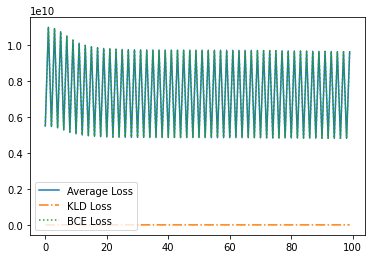

73.9128 secs


<Figure size 432x288 with 0 Axes>

In [ ]:
init_params = model.state_dict()
server_model=copy.deepcopy(model)
train_losses = []
KLD_losses = []
BCE_losses = []
for round_i in range(N_ROUNDS):
    train_loss = 0
    KLD_loss = 0
    BCE_loss = 0
    # latent_rep = []
    # latent_rep_mean = []
    print(f'============ Epoch: {round_i} ============')
    start_time = time.time()
    print(init_params['encoder.0.weight'])
    for client_dataset, client_model in zip(federated_dataset, models):
        optimizer = torch.optim.Adam(client_model.parameters(), lr=LR)
        X = get_data(client_dataset)
        client_model.load_state_dict(init_params)
        #client_model.data = [X.view(-1, 90635)]  # Set data attribute in client's model (list wraps the number of channels)
        for x in tqdm(X):
          x = x.to(device)
        
          # ===================forward=====================
          x_hat, mu, logvar, hidden = client_model(x.float())
        
          # latent_rep.extend(hidden.detach().clone().cpu().numpy())
          # latent_rep_mean.extend(mu.detach().clone().cpu().numpy())
        
          BCE, KLD = loss_function(x_hat, x, mu, logvar,ω)
          loss = KLD+BCE
          train_loss += loss.item()*x.size(0) 
          KLD_loss += KLD.item()*x.size(0) 
          BCE_loss += BCE.item()*x.size(0) 
        
          # ===================backward====================
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
    
        # Load client's model parameters and train
        #client_model.optimize(epochs=N_EPOCHS, data=client_model.data)
        avg_loss = train_loss / len(client_dataset.dataset)
        avg_KLD_loss = KLD_loss / len(client_dataset.dataset)
        avg_BCE_loss = BCE_loss / len(client_dataset.dataset)
        
    
        train_losses.append(avg_loss)
        KLD_losses.append(avg_KLD_loss)
        BCE_losses.append(avg_BCE_loss)

        trained_model = federated_averaging(models, n_obs_per_client)
        server_model = copy.deepcopy(trained_model)
        init_params = server_model.state_dict()


        print(f'''Average loss: {avg_loss :.4f}\t Avg KLD loss: {avg_KLD_loss :.4f}\t 
               Avg BCE loss: {avg_BCE_loss :.4f}''')


plt.plot(train_losses, label="Average Loss")
plt.plot(KLD_losses, label="KLD Loss", linestyle="-.")
plt.plot(BCE_losses, label="BCE Loss", linestyle=":")
plt.legend()
plt.show()
plt.clf()
    

# plot_UMAP(latent_rep, latent_rep_mean)
    
#torch.save(model.state_dict(), '/gdrive/MyDrive/UCI/VAE high quality data/weights_100/epoch_'+ str(epoch)+'.pt')
#torch.save(model.state_dict(), 'epoch_'+ str(epoch)+'.pt')
#torch.save(latent_rep, '/gdrive/MyDrive/UCI/VAE high quality data/hidden_rep_100/hidden_dim_epoch_'+ str(epoch) +'.pt')   

print(f"{((time.time() - start_time)) :.4f} secs")     
    # Aggregate models using federated averaging



============ Epoch: 0 ============



Average loss: 0.0000	 Avg KLD loss: 0.0000	 
               Avg BCE loss: 0.0000


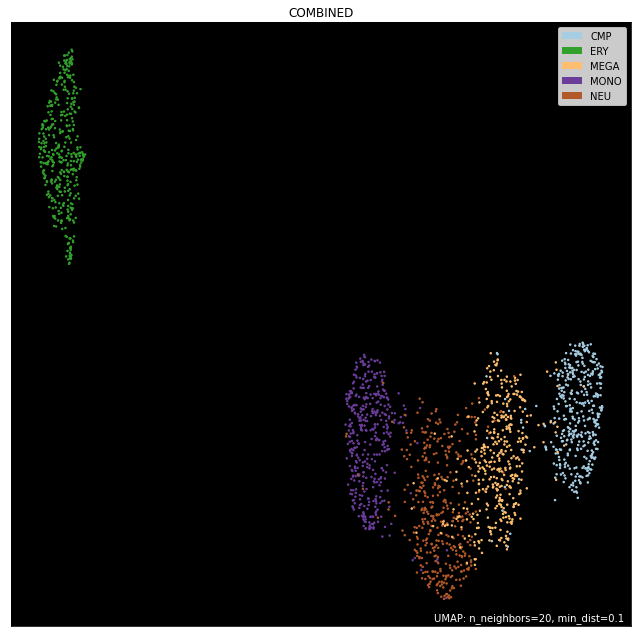

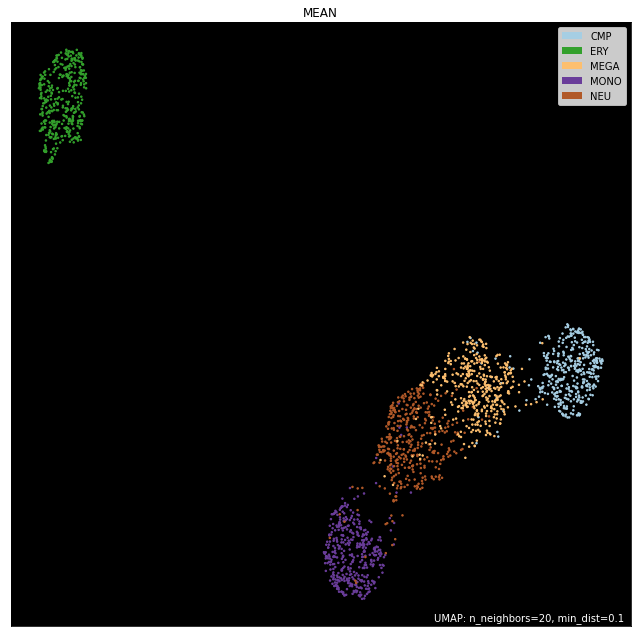

<Figure size 432x288 with 0 Axes>

In [ ]:
#optimizer = torch.optim.Adam(server_model.parameters(), lr=LR)
train_losses = []
KLD_losses = []
BCE_losses = []
for round_i in range(0,1):
    train_loss = 0
    KLD_loss = 0
    BCE_loss = 0
    latent_rep = []
    latent_rep_mean = []
    print(f'============ Epoch: {round_i} ============')
    start_time = time.time()
    #print(init_params['decoder.0.weight'])
    for x in tqdm(DataLoader(dataset= train_dataset, batch_size=BATCH_SIZE, shuffle=False)):
        x = x.to(device)
        
          # ===================forward=====================
        x_hat, mu, logvar, hidden = server_model(x.float())
        
        latent_rep.extend(hidden.detach().clone().cpu().numpy())
        latent_rep_mean.extend(mu.detach().clone().cpu().numpy())
        
        # BCE, KLD = loss_function(x_hat, x, mu, logvar,ω)
        # loss = KLD+BCE
        # train_loss += loss.item()*x.size(0) 
        # KLD_loss += KLD.item()*x.size(0) 
        # BCE_loss += BCE.item()*x.size(0) 
        
        #   # ===================backward====================
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
    
        # Load client's model parameters and train
        #client_model.optimize(epochs=N_EPOCHS, data=client_model.data)
    avg_loss = train_loss / 2000
    avg_KLD_loss = KLD_loss / 2000
    avg_BCE_loss = BCE_loss / 2000
        
    
    train_losses.append(avg_loss)
    KLD_losses.append(avg_KLD_loss)
    BCE_losses.append(avg_BCE_loss)

    print(f'''Average loss: {avg_loss :.4f}\t Avg KLD loss: {avg_KLD_loss :.4f}\t 
               Avg BCE loss: {avg_BCE_loss :.4f}''')

    

plot_UMAP(latent_rep, latent_rep_mean)



In [ ]:
# #epochs = 20
# train_losses = []
# KLD_losses = []
# BCE_losses = []
# for epoch in range(1, N_ROUNDS+1):
#     train_loss = 0
#     KLD_loss = 0
#     BCE_loss = 0
#     latent_rep = []
#     latent_rep_mean = []
#     print(f'============ Epoch: {epoch} ============')
#     start_time = time.time()

#     for x in tqdm(train_data_loader):
        
#         x = x.to(device)
        
#         # ===================forward=====================
#         x_hat, mu, logvar, hidden = model(x.float())
        
#         latent_rep.extend(hidden.detach().clone().cpu().numpy())
#         latent_rep_mean.extend(mu.detach().clone().cpu().numpy())
        
#         BCE, KLD = loss_function(x_hat, x, mu, logvar, ω)
#         loss = BCE + KLD
#         train_loss += loss.item() * x.size(0)
#         KLD_loss += KLD.item() * x.size(0)
#         BCE_loss += BCE.item() * x.size(0)
        
#         # ===================backward====================
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     avg_loss = train_loss / len(train_data_loader.dataset)
#     avg_KLD_loss = KLD_loss / len(train_data_loader.dataset)
#     avg_BCE_loss = BCE_loss / len(train_data_loader.dataset)
        
    
#     train_losses.append(avg_loss)
#     KLD_losses.append(avg_KLD_loss)
#     BCE_losses.append(avg_BCE_loss)

#     print(f'''Average loss: {avg_loss :.4f}\t Avg KLD loss: {avg_KLD_loss :.4f}\t 
#                 Avg BCE loss: {avg_BCE_loss :.4f}''')


# plt.plot(train_losses, label="Average Loss")
# plt.plot(KLD_losses, label="KLD Loss", linestyle="-.")
# plt.plot(BCE_losses, label="BCE Loss", linestyle=":")
# plt.legend()
# plt.show()
# plt.clf()
    

# plot_UMAP(latent_rep, latent_rep_mean)
    
# #torch.save(model.state_dict(), '/gdrive/MyDrive/UCI/VAE high quality data/weights_100/epoch_'+ str(epoch)+'.pt')
# torch.save(model.state_dict(), 'epoch_'+ str(epoch)+'.pt')
#     #torch.save(latent_rep, '/gdrive/MyDrive/UCI/VAE high quality data/hidden_rep_100/hidden_dim_epoch_'+ str(epoch) +'.pt')   

# print(f"{((time.time() - start_time)) :.4f} secs")     